# Notebook for benchmarking filtering on CPU

In [13]:
import numpy as np
import time
import tifffile
import scipy.signal

In [35]:
# open the file as a memmap 
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

## Try filtering chunks of data via numpy

In [36]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [45]:
latency = dict()
# try processing the first 100 5ms chunks of data
windows = [30, 150, 300, 750]
for j in windows:
    for i in range(1_000):
        ts = list()
        t = time.time()
        d = data[:, i:i + j]
        f = butter_filter(d, 1000, 30_000)
        ts.append(time.time() - t)
    latency[j] = sum(ts) / len(ts)

In [46]:
latency

{30: 0.0004353523254394531,
 150: 0.0008974075317382812,
 300: 0.00145721435546875,
 750: 0.003209352493286133}

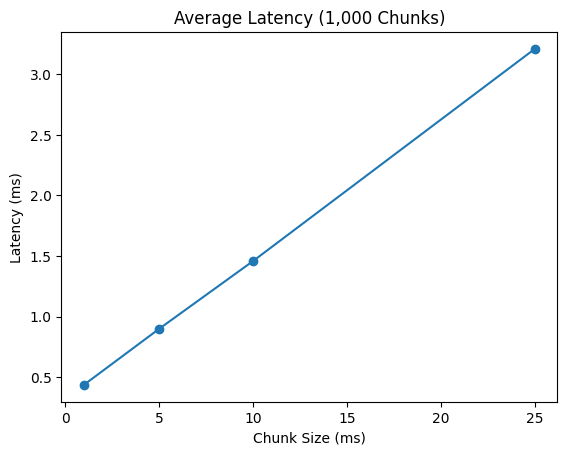

In [48]:
import matplotlib.pyplot as plt

x_values = [a / 30 for a in list(latency.keys())] 
y_values = [a * 1000 for a  in list(latency.values())]

plt.plot(x_values, y_values, marker='o', linestyle='-')

plt.xlabel('Chunk Size (ms)')
plt.ylabel('Latency (ms)')
plt.title('Average Latency (1,000 Chunks)')

plt.show()